# SAX Quick Start
> Let's go over the core functionality of SAX.

## Environment variables

SAX is based on JAX... here are some useful environment variables for working with JAX:

In [1]:
# select float32 or float64 as default dtype
%env JAX_ENABLE_X64=0

# select cpu or gpu
%env JAX_PLATFORM_NAME=cpu

# set custom CUDA location for gpu:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

# Using GPU?
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

env: JAX_ENABLE_X64=0
env: JAX_PLATFORM_NAME=cpu
env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda


cpu


## Imports

In [2]:
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt  # plotting
import sax
from tqdm.notebook import trange

## Scatter *dictionaries*
The core datastructure for specifying scatter parameters in SAX is a dictionary... more specifically a dictionary which maps a port combination (2-tuple) to a scatter parameter (or an array of scatter parameters when considering multiple wavelengths for example). Such a specific dictionary mapping is called ann `SDict` in SAX (`SDict ≈ Dict[Tuple[str,str], float]`).

Dictionaries are in fact much better suited for characterizing S-parameters than, say, (jax-)numpy arrays due to the inherent sparse nature of scatter parameters. Moreover, dictonaries allow for string indexing, which makes them much more pleasant to use in this context. Let’s for example create an `SDict` for a 50/50 coupler:

```
in1          out1
   \        /
    ========
   /        \
in0          out0
```

In [3]:
coupling = 0.5
kappa = coupling**0.5
tau = (1 - coupling) ** 0.5
coupler_dict = {
    ("in0", "out0"): tau,
    ("out0", "in0"): tau,
    ("in0", "out1"): 1j * kappa,
    ("out1", "in0"): 1j * kappa,
    ("in1", "out0"): 1j * kappa,
    ("out0", "in1"): 1j * kappa,
    ("in1", "out1"): tau,
    ("out1", "in1"): tau,
}
coupler_dict

{('in0', 'out0'): 0.7071067811865476,
 ('out0', 'in0'): 0.7071067811865476,
 ('in0', 'out1'): 0.7071067811865476j,
 ('out1', 'in0'): 0.7071067811865476j,
 ('in1', 'out0'): 0.7071067811865476j,
 ('out0', 'in1'): 0.7071067811865476j,
 ('in1', 'out1'): 0.7071067811865476,
 ('out1', 'in1'): 0.7071067811865476}

Only the non-zero port combinations need to be specified. Any non-existent port-combination (for example `("in0", "in1")`) is considered to be zero by SAX.

Obviously, it can still be tedious to specify every port in the circuit manually. SAX therefore offers the `reciprocal` function, which auto-fills the reverse connection if the forward connection exist. For example:

In [4]:
coupler_dict = sax.reciprocal(
    {
        ("in0", "out0"): tau,
        ("in0", "out1"): 1j * kappa,
        ("in1", "out0"): 1j * kappa,
        ("in1", "out1"): tau,
    }
)

coupler_dict

{('in0', 'out0'): 0.7071067811865476,
 ('in0', 'out1'): 0.7071067811865476j,
 ('in1', 'out0'): 0.7071067811865476j,
 ('in1', 'out1'): 0.7071067811865476,
 ('out0', 'in0'): 0.7071067811865476,
 ('out1', 'in0'): 0.7071067811865476j,
 ('out0', 'in1'): 0.7071067811865476j,
 ('out1', 'in1'): 0.7071067811865476}

## Parametrized Models

Constructing such an `SDict` is easy, however, usually we're more interested in having parametrized models for our components. To parametrize the coupler `SDict`, just wrap it in a function to obtain a SAX `Model`, which is a keyword-only function mapping to an `SDict`:

In [5]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling**0.5
    tau = (1 - coupling) ** 0.5
    coupler_dict = sax.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): 1j * kappa,
            ("in1", "out0"): 1j * kappa,
            ("in1", "out1"): tau,
        }
    )
    return coupler_dict


coupler(coupling=0.3)

{('in0', 'out0'): 0.8366600265340756,
 ('in0', 'out1'): 0.5477225575051661j,
 ('in1', 'out0'): 0.5477225575051661j,
 ('in1', 'out1'): 0.8366600265340756,
 ('out0', 'in0'): 0.8366600265340756,
 ('out1', 'in0'): 0.5477225575051661j,
 ('out0', 'in1'): 0.5477225575051661j,
 ('out1', 'in1'): 0.8366600265340756}

We can define a waveguide in the same way:

In [6]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )
    return sdict

That's pretty straightforward. Let's now move on to parametrized circuits:

## Circuit Models

Existing models can now be combined into a circuit using `sax.circuit`, which basically creates a new `Model` function:

In [7]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "lft": "coupler",
            "top": "waveguide",
            "btm": "waveguide",
            "rgt": "coupler",
        },
        "connections": {
            "lft,out0": "btm,in0",
            "btm,out0": "rgt,in0",
            "lft,out1": "top,in0",
            "top,out0": "rgt,in1",
        },
        "ports": {
            "in0": "lft,in0",
            "in1": "lft,in1",
            "out0": "rgt,out0",
            "out1": "rgt,out1",
        },
    },
    models={
        "coupler": coupler,
        "waveguide": waveguide,
    },
)

In [8]:
mzi()

{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out1'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('in1', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'in1'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('out1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

In [9]:
?mzi

The `circuit` function just creates a similar function as we created for the waveguide and the coupler, but in stead of taking parameters directly it takes parameter *dictionaries* for each of the instances in the circuit. The keys in these parameter dictionaries should correspond to the keyword arguments of each individual subcomponent. 

Let's now do a simulation for the MZI we just constructed:

In [10]:
%time mzi()

CPU times: user 13.6 ms, sys: 0 ns, total: 13.6 ms
Wall time: 13.4 ms


{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out1'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('in1', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'in1'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('out1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

In [11]:
mzi2 = jax.jit(mzi)

In [12]:
%time mzi2()

CPU times: user 95.4 ms, sys: 7.05 ms, total: 102 ms
Wall time: 102 ms


{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out1'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('in1', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'in1'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('out1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

In [13]:
%time mzi2()

CPU times: user 640 μs, sys: 71 μs, total: 711 μs
Wall time: 491 μs


{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out1'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('in1', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'in1'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(-0.57126822+0.82076344j, dtype=complex128),
 ('out1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

Or in the case we want an MZI with different arm lengths:

In [14]:
mzi(top={"length": 25.0}, btm={"length": 15.0})

{('in0', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in0', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in0', 'out0'): Array(-0.28072841+0.10397039j, dtype=complex128),
 ('in0', 'out1'): Array(0.89474612-0.33137758j, dtype=complex128),
 ('in1', 'in0'): Array(0.+0.j, dtype=complex128),
 ('in1', 'in1'): Array(0.+0.j, dtype=complex128),
 ('in1', 'out0'): Array(0.89474612-0.33137758j, dtype=complex128),
 ('in1', 'out1'): Array(0.28072841-0.10397039j, dtype=complex128),
 ('out0', 'in0'): Array(-0.28072841+0.10397039j, dtype=complex128),
 ('out0', 'in1'): Array(0.89474612-0.33137758j, dtype=complex128),
 ('out0', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out0', 'out1'): Array(0.+0.j, dtype=complex128),
 ('out1', 'in0'): Array(0.89474612-0.33137758j, dtype=complex128),
 ('out1', 'in1'): Array(0.28072841-0.10397039j, dtype=complex128),
 ('out1', 'out0'): Array(0.+0.j, dtype=complex128),
 ('out1', 'out1'): Array(0.+0.j, dtype=complex128)}

## Simulating the parametrized MZI

We can simulate the above mzi for multiple wavelengths as well by specifying the wavelength at the top level of the circuit call. Each setting specified at the top level of the circuit call will be propagated to all subcomponents of the circuit which have that setting:

In [15]:
wl = jnp.linspace(1.51, 1.59, 1000)
%time S = mzi(wl=wl, top={"length": 25.0}, btm={"length": 15.0})

CPU times: user 435 ms, sys: 12 ms, total: 447 ms
Wall time: 443 ms


Let's see what this gives:

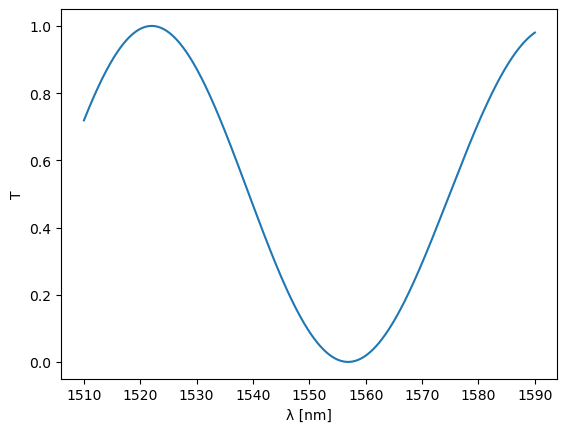

In [16]:
plt.plot(wl * 1e3, abs(S["in0", "out0"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.show()

## Optimization

We'd like to optimize an MZI such that one of the minima is at 1550nm. To do this, we need to define a loss function for the circuit at 1550nm. This function should take the parameters that you want to optimize as positional arguments:

In [17]:
@jax.jit
def loss_fn(delta_length):
    S = mzi(wl=1.55, top={"length": 15.0 + delta_length}, btm={"length": 15.0})
    return (abs(S["in0", "out0"]) ** 2).mean()

In [18]:
%time loss_fn(10.0)

CPU times: user 88.1 ms, sys: 41 μs, total: 88.1 ms
Wall time: 84.5 ms


Array(0.08961828, dtype=float64)

We can use this loss function to define a grad function which works on the parameters of the loss function:

In [19]:
grad_fn = jax.jit(
    jax.grad(
        loss_fn,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

Next, we need to define a JAX optimizer, which on its own is nothing more than three more functions:  an initialization function with which to initialize the optimizer state, an update function which will update the optimizer state (and with it the model parameters). The third function that's being returned will give the model parameters given the optimizer state.

In [20]:
initial_delta_length = 10.0
init_fn, update_fn, params_fn = opt.adam(step_size=0.1)
state = init_fn(initial_delta_length)

Given all this, a single training step can be defined:

In [21]:
def step_fn(step, state):
    settings = params_fn(state)
    loss = loss_fn(settings)
    grad = grad_fn(settings)
    state = update_fn(step, grad, state)
    return loss, state

And we can use this step function to start the training of the MZI:

In [22]:
range_ = trange(300)
for step in range_:
    loss, state = step_fn(step, state)
    range_.set_postfix(loss=f"{loss:.6f}")

  0%|          | 0/300 [00:00<?, ?it/s]

In [23]:
delta_length = params_fn(state)
delta_length

Array(9.93589743, dtype=float64)

Let's see what we've got over a range of wavelengths:

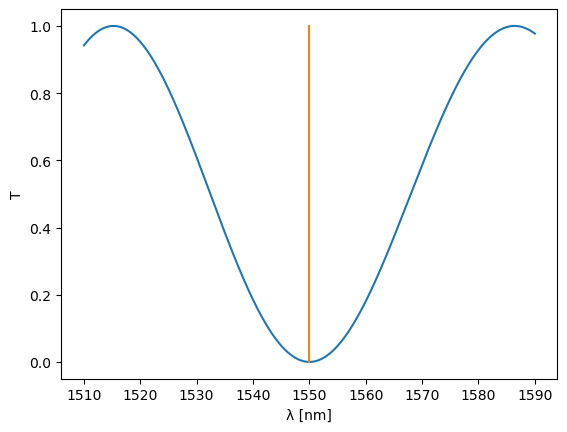

In [24]:
S = mzi(wl=wl, top={"length": 15.0 + delta_length}, btm={"length": 15.0})
plt.plot(wl * 1e3, abs(S["in1", "out1"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.plot([1550, 1550], [0, 1])
plt.show()

The minimum of the MZI is perfectly located at 1550nm.

## MZI Chain

Let's now create a chain of MZIs. For this, we first create a subcomponent: a directional coupler with arms:


```
                                 top
                            in0 ----- out0 -> out1
    in1 <- in1        out1                 
              \  dc  /                  
               ======                  
              /      \                
    in0 <- in0        out0       btm    
                            in0 ----- out0 -> out0
```

In [25]:
dc_with_arms, info = sax.circuit(
    netlist={
        "instances": {
            "lft": "coupler",
            "top": "waveguide",
            "btm": "waveguide",
        },
        "connections": {
            "lft,out0": "btm,in0",
            "lft,out1": "top,in0",
        },
        "ports": {
            "in0": "lft,in0",
            "in1": "lft,in1",
            "out0": "btm,out0",
            "out1": "top,out0",
        },
    },
    models={
        "coupler": coupler,
        "waveguide": waveguide,
    },
)

An MZI chain can now be created by cascading these directional couplers with arms:

```
      _    _    _    _             _    _  
    \/   \/   \/   \/     ...    \/   \/   
    /\_  /\_  /\_  /\_           /\_  /\_  
```

Let's create a *model factory* (`ModelFactory`) for this. In SAX, a *model factory* is any keyword-only function that generates a `Model`:

In [26]:
def mzi_chain(num_mzis=1) -> sax.Model:
    chain, _ = sax.circuit(
        netlist={
            "instances": {f"dc{i}": "dc_with_arms" for i in range(num_mzis + 1)},
            "connections": {
                **{f"dc{i},out0": f"dc{i+1},in0" for i in range(num_mzis)},
                **{f"dc{i},out1": f"dc{i+1},in1" for i in range(num_mzis)},
            },
            "ports": {
                "in0": f"dc0,in0",
                "in1": f"dc0,in1",
                "out0": f"dc{num_mzis},out0",
                "out1": f"dc{num_mzis},out1",
            },
        },
        models={"dc_with_arms": dc_with_arms},
    )
    return chain

Let's for example create a chain with 15 MZIs. We can also update the settings dictionary as follows:

In [27]:
chain = mzi_chain(num_mzis=15)
settings = sax.get_settings(chain)
for dc in settings:
    settings[dc]["top"]["length"] = 25.0
    settings[dc]["btm"]["length"] = 15.0
settings = sax.update_settings(settings, wl=jnp.linspace(1.5, 1.6, 1000))

We can simulate this:

In [28]:
%time S = chain(**settings) # time to evaluate the MZI
func = jax.jit(chain)
%time S = func(**settings) # time to jit the MZI
%time S = func(**settings) # time to evaluate the MZI after jitting

CPU times: user 528 ms, sys: 64.8 ms, total: 592 ms
Wall time: 581 ms


CPU times: user 2.07 s, sys: 50.9 ms, total: 2.12 s
Wall time: 2.1 s
CPU times: user 46.6 ms, sys: 20.3 ms, total: 66.9 ms
Wall time: 62.4 ms


Where we see that the unjitted evaluation of the MZI chain takes about a second, while the jitting of the MZI chain takes about two seconds (on a CPU). However, after the MZI chain has been jitted, the evaluation is in the order of about a few milliseconds!

Anyway, let's see what this gives:

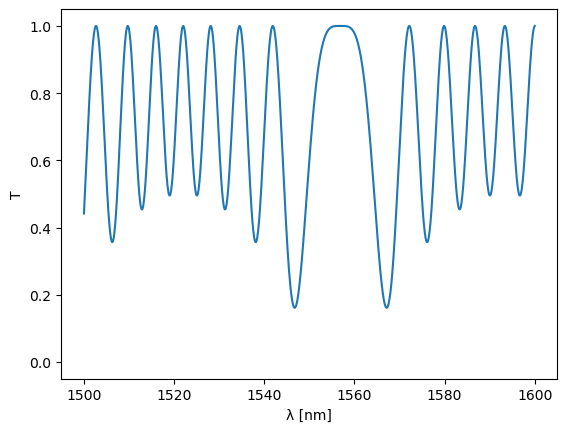

In [29]:
S = sax.sdict(S)
plt.plot(1e3 * settings["dc0"]["top"]["wl"], jnp.abs(S["in0", "out0"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.show()